<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Superdense Coding*_ 

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).
***
### Contributor
Anna Phan

## Introduction

Superdense coding is a protocol to transmit two classical bits of information using only one qubit. It was devised by Charles Bennett (IBM) and Stephen Wiesner in [1992](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.69.2881). 

The protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$$
The first qubit, denoted by subscript $A$, belongs to Alice and the second qubit, $B$, belongs to Bob.

Alice wants to send a two bit message to Bob, 00, 01, 10, or 11.  She performs a single qubit operation on her qubit which transforms the entangled state according to which message she wants to send:
- For a message of **00**: Alice applies $I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$. The resultant state would be $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$
- For a message of **01**: Alice applies $X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$. The resultant state would be $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$  
- For a message of **10**: Alice applies $Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$. The resultant state would be $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$ 
- For a message of **11**: Alice applies $XZ = \begin{bmatrix} 0 & -1 \\ 1 & 0 \end{bmatrix}$. The resultant state would be $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $

The key to superdense coding is that these four states, $|\psi_{00}\rangle, |\psi_{01}\rangle, |\psi_{10}\rangle, |\psi_{11}\rangle$ (otherwise known as the [Bell states](https://en.wikipedia.org/wiki/Bell_state)), are orthonormal and are hence distinguishable by a quantum measurement.

## Implementation

The first step is to import the required packages to run the Quantum Experience and set up our quantum program.

In [1]:
# Checking the version of Python; the Quantum Experience currently only supports version 3
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
# Importing QISKit
import sys
sys.path.append("../../")
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# Import basic plotting tools
from tools.visualization import plot_histogram

# Quantum program setup 
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

Recall from [superposition and entanglement](superposition_and_entanglement.ipynb) and [entanglement revisited](entanglement_revisited.ipynb), the steps to make the shared entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$ are:
1. Start with an initial state $|0_A 0_B\rangle$
2. Apply $H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$ on $q_A$ 
3. Then a $CNOT = \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{bmatrix}$ from $q_A$ to $q_B$

With $q_A = q_0$ and $q_B = q_1$, this looks like:

In [2]:
# Creating registers
q = Q_program.create_quantum_register("q", 2)
c = Q_program.create_classical_register("c", 2)

# Quantum circuit to make the shared entangled state 
superdense = Q_program.create_circuit("superdense", [q], [c])
superdense.h(q[0])
superdense.cx(q[0], q[1])

Alice now needs to decide what two bit message she wants to transmit to Bob, ($00$, $01$, $10$, or $11$), and perform the corresponding to transformation ($I$, $X$, $Z$ or $XZ$ respectively) to her qubit $q_A$ ($q_0$). In this case, she encodes $11$:

In [3]:
# For 00, do nothing

# For 01, apply $X$
#shared.x(q[0])

# For 01, apply $Z$
#shared.z(q[0])

# For 11, apply $XZ$
superdense.z(q[0]) 
superdense.x(q[0])
superdense.barrier()

Bob now needs to 'decode' the message that Alice sent him. Since measurement in the Quantum Experience is only possible in the standard computational basis, he does this by:
1. Applying a $CNOT$ from $q_A$ to $q_B$
2. Then a $H$ on $q_A$ 
3. And measuring $q_A$ and $q_B$

Recalling that $q_A = q_0$ and $q_B = q_1$, this looks like:

In [4]:
superdense.cx(q[0], q[1])
superdense.h(q[0])
superdense.measure(q[0], c[0])
superdense.measure(q[1], c[1])

Let's now create, execute the quantum circuits, and plot the results:

In [5]:
circuits = ["superdense"]
print(Q_program.get_qasms(circuits)[0])

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
z q[0];
x q[0];
barrier q[0],q[1];
cx q[0],q[1];
h q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];



In [6]:
backend = 'ibmqx2'  # the device to run on
shots = 1024       # the number of shots in the experiment 

result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

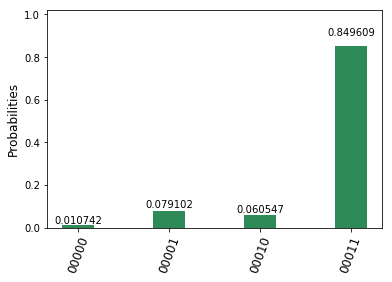

In [7]:
plot_histogram(result.get_counts("superdense"))

The state with the highest probability should match the message that Alice encoded earlier ($11$). Mathematically:
- For a message of **00**: Bob received $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle + (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |0_A 0_B\rangle$ 
- For a message of **01**: Bob received $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle)+ |1_A 1_B\rangle$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle + (|0_A\rangle - |1_A\rangle)|1_B\rangle + (|0_A\rangle + |1_A\rangle)|1_B\rangle] = |0_A 1_B\rangle$ 
- For a message of **10**: Bob received $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle - (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |1_A 0_B\rangle$ 
- For a message of **11**: Bob received $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle - |1_A 1_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle - (|0_A\rangle - |1_A\rangle)|1_B\rangle] = |1_A 1_B\rangle$ 